In [1]:
#%%
import os
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm
import pickle 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch.backends.cuda
torch.backends.cuda.enable_flash_sdp(False)



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
#%%
# Select platform
platform = "xenium" # xenium or visium 
ground_truth = "refined"  # refined or cellvit
level = 0
filtered_genes = False
label_source = "singleR"  # singleR, celltypist, aistil, combined
morph_version = "v2"
use_qc = False
fusion_decoder = False
use_projections = True
limit_classes = True  # Set to False to use all classes


if platform == "xenium":
    cancer = "lung"
    xenium_folder_dict = {"lung": "Xenium_Prime_Human_Lung_Cancer_FFPE_outs",
                          "breast":"Xenium_Prime_Breast_Cancer_FFPE_outs",
                          "lymph_node": "Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs",
                          "prostate": "Xenium_Prime_Human_Prostate_FFPE_outs",
                          "skin": "Xenium_Prime_Human_Skin_FFPE_outs",
                          "ovarian": "Xenium_Prime_Ovarian_Cancer_FFPE_outs",
                          "cervical": "Xenium_Prime_Cervical_Cancer_FFPE_outs"
                          }

    xenium_folder = xenium_folder_dict[cancer]
    celltypist_data_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_ImmuneHigh_v2.h5ad"
    singleR_data_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_v2_annotated.h5ad"
    
    embedding_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}"

    gene_emb_path = f"{embedding_dir}/scGPT/scGPT_CP.h5ad"

    # if filtered_genes:
    #     gene_embedding_file = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}/processed_xenium_refined_clustering_filtered_v2.csv"
    # else:
    #     gene_embedding_file = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}/processed_xenium_{ground_truth}_v2.csv"
    
    # Load Morphological Embeddings

        
elif platform == "visium":
    data_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_002um/preprocessed/bin2cell/to_tokenize/corrected_cells_matched_preprocessed_refined_v2.h5ad"
    singleR_data_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_002um/preprocessed/bin2cell/corrected_cells_matched_preprocessed_refined_v2_annotated.h5ad"

    # gene_embedding_file = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/bin2cell/embeddings_output/processed_visium_hd_bin2cell.csv"
    embedding_dir = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/"
    gene_emb_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/b2c_scGPT_WH.h5ad"


# Load AnnData
if label_source == "singleR":
    data_path = singleR_data_path
    adata = sc.read_h5ad(data_path)
    
    
elif label_source == "celltypist":
    data_path = celltypist_data_path
    adata = sc.read_h5ad(data_path)
    
elif label_source == "combined":
    adata = sc.read_h5ad(singleR_data_path)
    bdata = sc.read_h5ad(celltypist_data_path)
    adata.obs["majority_voting"] = bdata.obs["majority_voting"]
    adata.obs["qc_celltypist"] = bdata.obs["qc_celltypist"]
    cell_data = adata.obs

cell_data = adata.obs
print("Cell data shape:", cell_data.shape)
# Load Morphology Embeddings 
if morph_version == "v1":
    morph_embedding_csv = os.path.join(embedding_dir, "UNI2_cell_representation",f"level_{level}","morphology_embeddings_v2.csv")  
else:
    morph_embedding_csv = os.path.join(embedding_dir, "UNI2_cell_representation",f"level_{level}","uni2_pretrained_embeddings.csv") 

morph_embeddings = pd.read_csv(morph_embedding_csv, index_col="Unnamed: 0")

# Load gene Embeddings 
# gene_embeddings = pd.read_csv(gene_embedding_file, index_col="Unnamed: 0")
gdata = sc.read_h5ad(gene_emb_path)


if platform == "visium":
    # Ensure index alignment
    cell_data.index = cell_data.index.astype(str)
    gdata.obs_names = gdata.obs_names.astype(str)
    morph_embeddings.index = morph_embeddings.index.astype(str)
    
    # Filter cell_data to match gene embeddings
    cell_data = cell_data.loc[gdata.obs_names]

    # Align morphology embeddings to gene_embeddings (which should already be filtered)
    morph_embeddings = morph_embeddings.loc[cell_data.index]


# Now create gene_embeddings with matching index
gene_embeddings = pd.DataFrame(gdata.obsm["X_scGPT"], index=gdata.obs_names)

assert (morph_embeddings.index == gene_embeddings.index).all(), "Indices are not aligned!"

# Spatial Information 
spatial_coords = cell_data[['x_centroid', 'y_centroid']].rename(columns={'x_centroid': 'x', 'y_centroid': 'y'})


if label_source=="singleR":
    print("Using labels from SingleR.")
    singleR_to_class_map = {
        "Smooth muscle": "fibroblast",
        "Fibroblasts": "fibroblast",
        "Endothelial cells": "endothelial",
        "CD4+ T-cells": "t_cell",
        "CD8+ T-cells": "t_cell",
        "B-cells": "b_cell",
        "Macrophages": "macrophage",
        "Epithelial cells": "epithelial",
    }
    
    target_classes = ["fibroblast", "endothelial",
                      "t_cell", "b_cell", "macrophage",
                      "epithelial"]
    
    # Map SingleR labels to 7-class system
    cell_data[label_source] = cell_data["singleR_class"].map(singleR_to_class_map)
    
    # Drop cells that are nan (if any)
    # cell_data = cell_data.dropna(subset=[label_source])
    
    # Keep only those 7 classes
    # cell_data = cell_data[cell_data[label_source].isin(target_classes)]
    print("Cell data shape:", cell_data.shape)

    
    if use_qc:
        cell_data = cell_data[cell_data["qc_singleR"]==1]

    
    # Reindex embeddings/coords
    gene_embeddings = gene_embeddings.reindex(cell_data.index)
    morph_embeddings = morph_embeddings.reindex(cell_data.index)
    spatial_coords = spatial_coords.reindex(cell_data.index)
    print("finished loading data")
    
elif label_source=="aistil":
    print("Using AISTIL labels")
    label_source = "class"
    target_classes = ["f", "l", "t"]  # Modify this list to restrict classification to specific classes
    if limit_classes:
        num_classes = len(target_classes)
        cell_data = cell_data[cell_data[label_source].isin(target_classes)]

        # Change index type for Visium data to match embeddings Idxs 
        if platform == "visium":
            morph_embeddings.index = morph_embeddings.index.astype(str)

        # Update corresponding embeddings and spatial coordinates
        gene_embeddings = gene_embeddings.reindex(cell_data.index)
        morph_embeddings = morph_embeddings.reindex(cell_data.index)
        spatial_coords = spatial_coords.reindex(cell_data.index)
    else:
        target_classes = ["f","l","o","t"]
        
elif label_source=="celltypist":
    print("Using CellTypist Labels")
    celltypist_to_class_map = {
        "Fibroblasts": "fibroblast",
        "Endothelial cells": "endothelial",
        "T cells": "t_cell",
        "B cells": "b_cell",
        "Macrophages": "macrophage",
        "Epithelial cells": "epithelial",
    }
    target_classes = ["fibroblast", "endothelial",
                      "t_cell", "b_cell", "macrophage",
                      "epithelial"]

    # Map SingleR labels to 7-class system
    cell_data[label_source] = cell_data["majority_voting"].map(celltypist_to_class_map)
    
    # Drop cells that are nan (if any)
    # cell_data = cell_data.dropna(subset=[])
    
    # Keep only those 7 classes
    # cell_data = cell_data[cell_data[label_source].isin(target_classes)]

    if use_qc:
        cell_data = cell_data[cell_data["qc_celltypist"]==1]

    # Reindex embeddings/coords
    gene_embeddings = gene_embeddings.reindex(cell_data.index)
    morph_embeddings = morph_embeddings.reindex(cell_data.index)
    spatial_coords = spatial_coords.reindex(cell_data.index)
    
elif label_source == "combined":
    print("Using combined SingleR and CellTypist labels (agreement only)")

    # Define the shared label map and target classes
    shared_class_map = {
        "Fibroblasts": "fibroblast",
        "Smooth muscle": "fibroblast",
        "Endothelial cells": "endothelial",
        "CD4+ T-cells": "t_cell",
        "CD8+ T-cells": "t_cell",
        "T cells": "t_cell",
        "B cells": "b_cell",
        "B-cells": "b_cell",
        "Macrophages": "macrophage",
        "Epithelial cells": "epithelial",
    }
    
    target_classes = ["fibroblast", "endothelial", "t_cell", "b_cell", "macrophage", "epithelial"]

    # First map the labels (these are safe)
    cell_data["singleR_mapped"] = cell_data["singleR_class"].map(shared_class_map)
    cell_data["celltypist_mapped"] = cell_data["majority_voting"].map(shared_class_map)
    
    # Then immediately filter with a properly aligned mask
    cell_data = cell_data[
        cell_data["singleR_mapped"].notnull() &
        cell_data["celltypist_mapped"].notnull() &
        (cell_data["singleR_mapped"] == cell_data["celltypist_mapped"])
    ].copy()
    

    # Rename the final label column
    cell_data["combined"] = cell_data["singleR_mapped"]
    
    if use_qc:
        qc_mask = cell_data["qc_singleR"] == 1
        if "qc_celltypist" in cell_data.columns:
            qc_mask &= cell_data["qc_celltypist"] == 1
        cell_data = cell_data[qc_mask]

    # Reindex everything to the filtered cells
    gene_embeddings = gene_embeddings.reindex(cell_data.index)
    morph_embeddings = morph_embeddings.reindex(cell_data.index)
    spatial_coords = spatial_coords.reindex(cell_data.index)



print("Mapping labels")
num_classes = len(target_classes)
label_mapping = {cls_name: i for i, cls_name in enumerate(target_classes)}
labels = pd.Series(cell_data[label_source].map(label_mapping))

Cell data shape: (244659, 40)
Using labels from SingleR.
Cell data shape: (244659, 41)
finished loading data
Mapping labels


In [3]:
# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
# Convert dataframes to tensors
gene_tensor = torch.tensor(gene_embeddings.values, dtype=torch.float32).to(device)
morph_tensor = torch.tensor(morph_embeddings.values, dtype=torch.float32).to(device)
print(gene_tensor.shape)
# Confirm shapes match
assert gene_tensor.shape[0] == morph_tensor.shape[0], "Mismatch in cell counts."

torch.Size([244659, 512])


In [5]:
# ────────── Config ──────────
# reg_type = "l2"      # "none", "l1", or "l2"
# reg_lambda = 1e-4      # strength of the penalty
l1_lambda = 1e-4
l2_lambda = 1e-4
tau = 0.07
pro_dim = 128
lr = 1e-3


metrics = {"none":                      # one list per metric
        {"epoch"     : [],
        "avg_loss"  : [],
        "w_norm_g"  : [],
        "w_norm_m"  : [],
        "emb_std_g" : [],
        "emb_std_m" : [],
        "cos_gap"   : [],
        "run_tag"   : []},
           "l1": 
        {"epoch"     : [],
        "avg_loss"  : [],
        "w_norm_g"  : [],
        "w_norm_m"  : [],
        "emb_std_g" : [],
        "emb_std_m" : [],
        "cos_gap"   : [],
        "run_tag"   : []},
           "l2":
           {"epoch"     : [],
        "avg_loss"  : [],
        "w_norm_g"  : [],
        "w_norm_m"  : [],
        "emb_std_g" : [],
        "emb_std_m" : [],
        "cos_gap"   : [],
        "run_tag"   : []},
    }

lambda_dict = {"none":0.0, "l1":l1_lambda, "l2":l2_lambda}

In [6]:
class ProjectionNet(nn.Module):
    def __init__(self, input_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
# ---------- losses ----------
def info_nce(anchor, positive, t=tau):
    a = F.normalize(anchor, dim=1); p = F.normalize(positive, dim=1)
    return F.cross_entropy(a @ p.T / t,
                           torch.arange(a.size(0), device=a.device))
    
def regularization_loss(params, ptype="none", lam=1e-4):
    if ptype == "none":
        return 0.0
    if ptype == "l2":          # ‖W‖²
        return lam * sum((p**2).sum() for p in params)
    if ptype == "l1":          # ‖W‖₁
        return lam * sum(p.abs().sum() for p in params)
    raise ValueError(f"Unknown reg type: {ptype}")

def log_stats(tag, epoch_idx, avg_loss,
              gene_net, morph_net,
              gene_tensor, morph_tensor,
              metrics_dict):
    """
    Collect quick diagnostics and store them in metrics_dict.
    """
    with torch.no_grad():
        # weight norms
        w_norm_g = torch.cat([p.flatten()
                              for p in gene_net.parameters()]).norm().item()
        w_norm_m = torch.cat([p.flatten()
                              for p in morph_net.parameters()]).norm().item()

        # sample 10 k points for speed
        k   = 10_000
        sel = torch.randperm(gene_tensor.size(0))[:k]
        g_n = F.normalize(gene_net(gene_tensor[sel]), dim=1)
        m_n = F.normalize(morph_net(morph_tensor[sel]), dim=1)

        pos = (g_n * m_n).sum(1).mean()
        neg = (g_n @ m_n.T).topk(2, dim=1).values[:, 1].mean()
        cos_gap = (pos - neg).item()

    # append to lists
    metrics_dict[reg_type]["epoch"].append(epoch_idx)
    metrics_dict[reg_type]["avg_loss"].append(avg_loss)
    metrics_dict[reg_type]["w_norm_g"].append(w_norm_g)
    metrics_dict[reg_type]["w_norm_m"].append(w_norm_m)
    metrics_dict[reg_type]["emb_std_g"].append(g_n.std().item())
    metrics_dict[reg_type]["emb_std_m"].append(m_n.std().item())
    metrics_dict[reg_type]["cos_gap"].append(cos_gap)
    metrics_dict[reg_type]["run_tag"].append(tag)





In [8]:
def train_conch(gene_data, morph_data, metrics, epochs=100, batch_size=512, lr=1e-4, verbose=1):
    optimizer = optim.Adam(
        list(gene_proj_net.parameters()) + list(morph_proj_net.parameters()),
        lr=lr
    )

    dataset_size = gene_data.shape[0]
    indices = np.arange(dataset_size)

    
    for epoch in range(epochs):
        np.random.shuffle(indices)
        epoch_loss = 0

        for start_idx in range(0, dataset_size, batch_size):
            end_idx = min(start_idx + batch_size, dataset_size)
            batch_idx = indices[start_idx:end_idx]

            gene_batch = gene_data[batch_idx]
            morph_batch = morph_data[batch_idx]

            # Project embeddings
            gene_proj = gene_proj_net(gene_batch)
            morph_proj = morph_proj_net(morph_batch)


             # ───── debug only ONCE ───────────────────────────
            if epoch == 0 and start_idx == 0:          # first iteration
                with torch.no_grad():
                    g = gene_proj[:8]
                    m = morph_proj[:8]
                    cos = F.normalize(g, dim=1) @ F.normalize(m, dim=1).T
                    print("Initial stats  |  proj std:",
                          g.std().item(), m.std().item(),
                          "|  cos range:", cos.min().item(), cos.max().item())

            # Compute InfoNCE loss (positive pairs = same cell)
            loss_gene_to_morp = info_nce(gene_proj, morph_proj)
            loss_morph_to_gene = info_nce(morph_proj, gene_proj)
            ce_loss = (loss_gene_to_morp + loss_morph_to_gene) / 2

            # === add regularisation here ===
            reg_loss = regularization_loss(
                list(gene_proj_net.parameters()) + list(morph_proj_net.parameters()),
                ptype=reg_type, lam=reg_lambda
            )
            loss = ce_loss + reg_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (dataset_size // batch_size)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")
        
        log_stats(run_tag, epoch+1, avg_loss,
              gene_proj_net, morph_proj_net,
              gene_tensor, morph_tensor,
              metrics)
        





Training model: none-0
Initial stats  |  proj std: 0.03493024408817291 0.07133068889379501 |  cos range: -0.09806019812822342 0.09688255935907364
Finished training


2025-05-22 22:56:23.614987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 22:56:23.730086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 22:56:23.730807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 22:56:23.864957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 22:56:25.001617: W tensorflow/compiler/tf

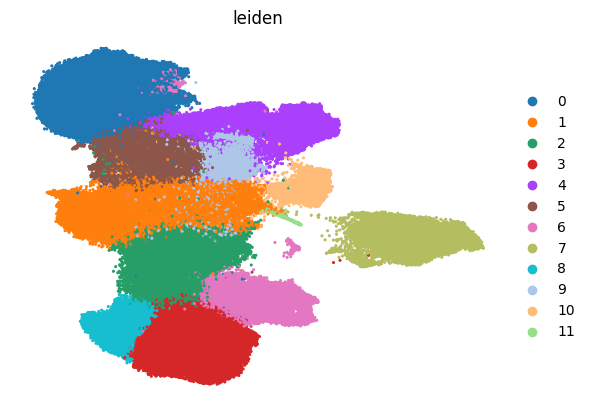

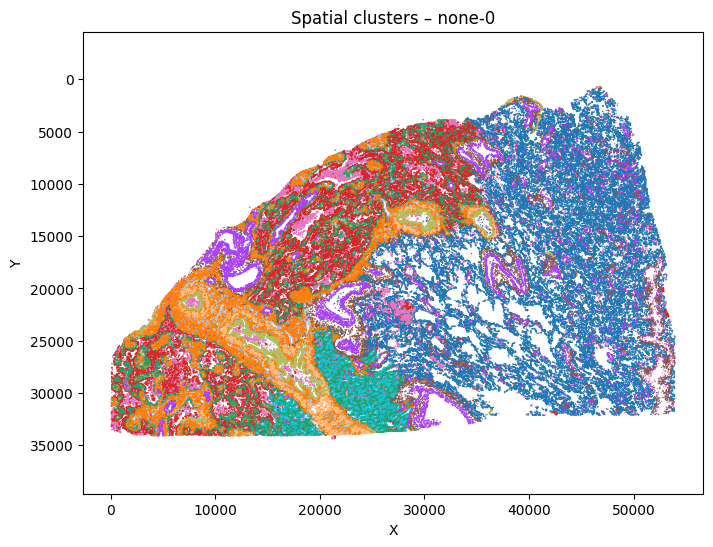


=== Inference metrics – none-0 ===

ARI         :  0.175
NMI         :  0.278
Homogeneity :  0.254
Completeness:  0.307
Purity      :  0.405
Silhouette  :  0.055
DaviesBouldin:  2.931
CalinskiHarabasz:  5567.903
kNN-hit@5   :  0.611

Training model: l1-0.0001
Initial stats  |  proj std: 0.04003383591771126 0.07382819801568985 |  cos range: -0.06677060574293137 0.08296465128660202
Finished training


IOStream.flush timed out


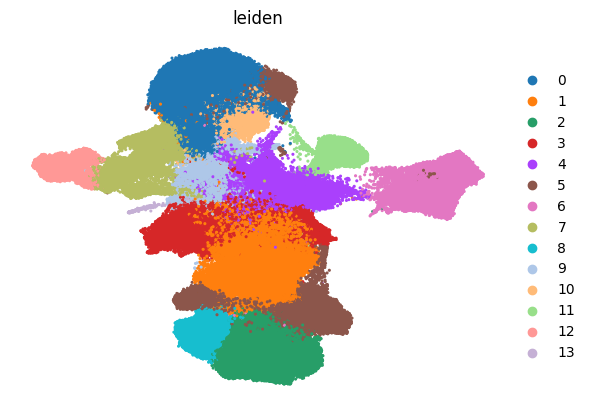

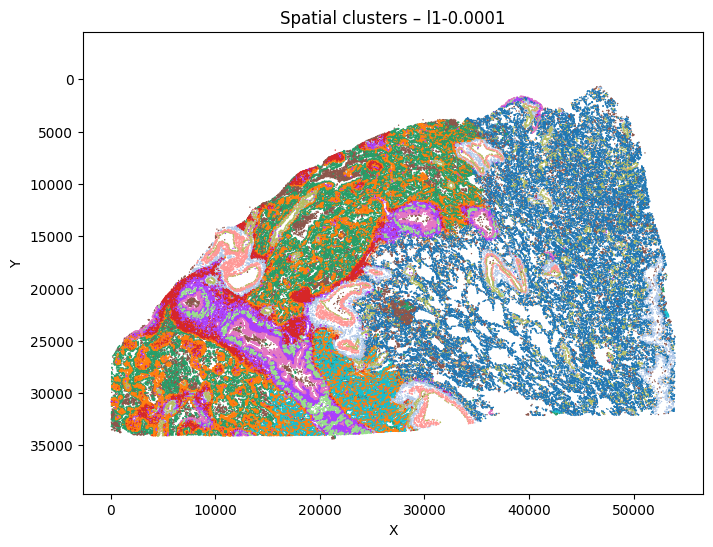


=== Inference metrics – l1-0.0001 ===

ARI         :  0.171
NMI         :  0.268
Homogeneity :  0.253
Completeness:  0.285
Purity      :  0.415
Silhouette  :  0.119
DaviesBouldin:  2.231
CalinskiHarabasz:  11834.013
kNN-hit@5   :  0.600

Training model: l2-0.0001
Initial stats  |  proj std: 0.03762887045741081 0.06354028731584549 |  cos range: -0.2431585043668747 -0.027286404743790627
Finished training


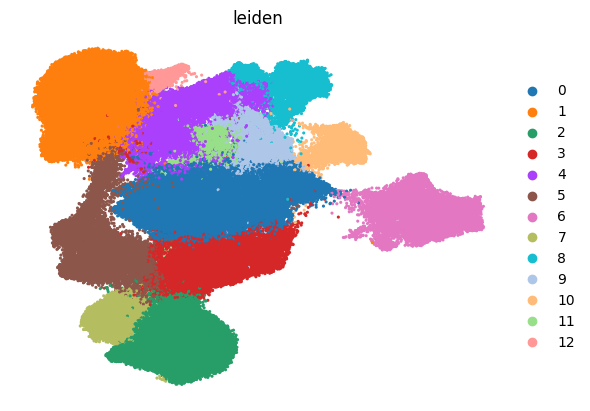

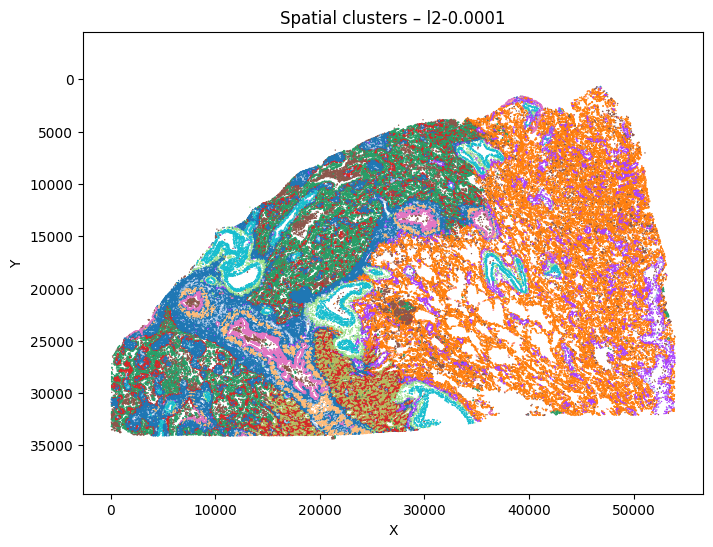


=== Inference metrics – l2-0.0001 ===

ARI         :  0.172
NMI         :  0.275
Homogeneity :  0.253
Completeness:  0.302
Purity      :  0.410
Silhouette  :  0.088
DaviesBouldin:  2.732
CalinskiHarabasz:  6499.511
kNN-hit@5   :  0.609


In [9]:
results = {}          # create once, outside any loop
for reg_type in ["none", "l1","l2"]:
    reg_lambda = lambda_dict[reg_type]
    run_tag = f"{reg_type}-{reg_lambda:g}"      #  "l2-1e-4"
    # Initialize projection networks
    gene_proj_net = ProjectionNet(input_dim=gene_tensor.shape[1]).to(device)
    morph_proj_net = ProjectionNet(input_dim=morph_tensor.shape[1]).to(device)
    print(f"\nTraining model: {run_tag}")
    train_conch(gene_tensor, morph_tensor,metrics, epochs=200, batch_size=1024, lr=lr, verbose=0)
    print("Finished training")
    import scanpy as sc, pandas as pd, numpy as np, torch
    from sklearn.metrics import (
        adjusted_rand_score, normalized_mutual_info_score,
        homogeneity_score, completeness_score, silhouette_score,
        davies_bouldin_score, calinski_harabasz_score
    )
    from sklearn.neighbors import KNeighborsClassifier
    
    # ------------------------------------------------------------------
    #   Build joint embeddings (same as you already do)
    # ------------------------------------------------------------------
    with torch.no_grad():
        g_z = gene_proj_net(gene_tensor).cpu()
        m_z = morph_proj_net(morph_tensor).cpu()
    joint = 0.5 * (g_z + m_z)                       # (N,128)
    
    adata = sc.AnnData(m_z.numpy(),
                       obs=pd.DataFrame(index=gene_embeddings.index))
    
    sc.pp.neighbors(adata, n_neighbors=15, use_rep="X")
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5)

    # -----------------------------------------------------------
    #   DISPLAY the plots (unchanged)
    # -----------------------------------------------------------
    sc.pl.umap(adata, color="leiden", size=20,
               legend_loc="right margin", frameon=False)   # still shows
    
    # add spatial coords if you haven't already
    adata.obs["x"] = spatial_coords.loc[adata.obs_names, "x"]
    adata.obs["y"] = spatial_coords.loc[adata.obs_names, "y"]
    
    cluster_colors = adata.obs["leiden"].astype(str).map(
        {str(i): c for i,c in enumerate(adata.uns["leiden_colors"])})
    
    plt.figure(figsize=(8,6))
    plt.scatter(adata.obs["x"], adata.obs["y"],
                c=cluster_colors, s=1, linewidth=0)
    plt.gca().invert_yaxis()
    plt.axis("equal")
    plt.title(f"Spatial clusters – {run_tag}")
    plt.xlabel("X"); plt.ylabel("Y")
    plt.show()                                          # still shows


    
    # ------------------------------------------------------------------
    #.  External cluster–label agreement  (needs existing labels)
    # ------------------------------------------------------------------
    adata.obs["true_label"] = cell_data["singleR_class"]   # strings
    
    clust = adata.obs["leiden"].astype(int).values
    true  = adata.obs["true_label"].values
    
    ext_metrics = {
        "ARI"          : adjusted_rand_score(true, clust),
        "NMI"          : normalized_mutual_info_score(true, clust),
        "Homogeneity"  : homogeneity_score(true, clust),
        "Completeness" : completeness_score(true, clust)
    }
    
    # cluster purity (majority-vote)
    cm      = pd.crosstab(true, clust)
    purity  = cm.max(axis=0).sum() / cm.sum().sum()
    ext_metrics["Purity"] = purity
    
    # ------------------------------------------------------------------
    #   Internal metrics  (no labels required)
    # ------------------------------------------------------------------
    X = m_z.numpy()
    int_metrics = {
        "Silhouette"       : silhouette_score(X, clust, sample_size=20000),
        "DaviesBouldin"    : davies_bouldin_score(X, clust),
        "CalinskiHarabasz" : calinski_harabasz_score(X, clust)
    }
    
    # ------------------------------------------------------------------
    #.  Local label-consistency (k-NN hit-rate)
    # ------------------------------------------------------------------
    mask = ~pd.isna(true)          # some cells may be unlabeled
    knn   = KNeighborsClassifier(5).fit(X[mask], true[mask])
    knn_acc = knn.score(X[mask], true[mask])
    
    # ------------------------------------------------------------------
    #   Summarise
    # ------------------------------------------------------------------
    print("\n=== Inference metrics –", run_tag, "===\n")
    for k,v in ext_metrics.items():
        print(f"{k:12s}: {v: .3f}")
    for k,v in int_metrics.items():
        print(f"{k:12s}: {v: .3f}")
    print(f"{'kNN-hit@5':12s}: {knn_acc: .3f}")
    
    # Optional: collect in a dict to compare runs later
    results[run_tag] = {**ext_metrics, **int_metrics, "kNN": knn_acc}

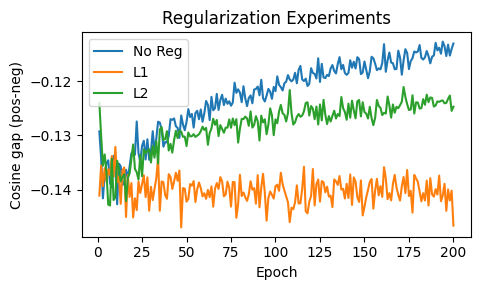

In [10]:

df_none = pd.DataFrame(metrics["none"])
df_l1 = pd.DataFrame(metrics["l1"])
df_l2 = pd.DataFrame(metrics["l2"])

plt.figure(figsize=(5,3))
plt.plot(df_none["epoch"], df_none["cos_gap"], label="No Reg")
plt.plot(df_l1["epoch"], df_l1["cos_gap"], label="L1")
plt.plot(df_l2["epoch"], df_l2["cos_gap"], label="L2")

plt.xlabel("Epoch")
plt.ylabel("Cosine gap (pos-neg)")
plt.title("Regularization Experiments")
plt.legend()
plt.tight_layout()
plt.show()

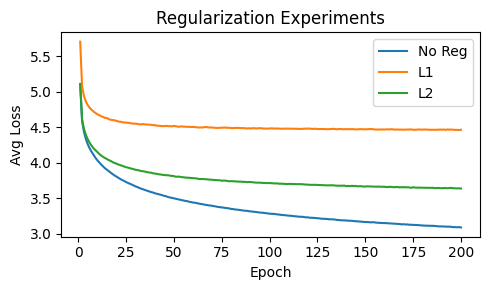

In [11]:
plt.figure(figsize=(5,3))
plt.plot(df_none["epoch"], df_none["avg_loss"], label="No Reg")
plt.plot(df_l1["epoch"], df_l1["avg_loss"], label="L1")
plt.plot(df_l2["epoch"], df_l2["avg_loss"], label="L2")

plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Regularization Experiments")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# After training, compute final embeddings

with torch.no_grad():
    gene_emb_final = gene_proj_net(gene_tensor).cpu().numpy()
    morph_emb_final = morph_proj_net(morph_tensor).cpu().numpy()

# Combine embeddings (e.g., average)
joint_embeddings = (gene_emb_final + morph_emb_final) / 2

# Save embeddings
gene_emb_df = pd.DataFrame(gene_emb_final, index=gene_embeddings.index)
morph_emb_df = pd.DataFrame(morph_emb_final, index=gene_embeddings.index)
joint_emb_df = pd.DataFrame(joint_embeddings, index=gene_embeddings.index)

# os.makedirs(os.path.join(embedding_dir,"contrastive_learning"), exist_ok=True)
# gene_emb_df.to_csv(os.path.join(embedding_dir,"contrastive_learning", f"gene_projection_embeddings_{morph_version}.csv"))
# morph_emb_df.to_csv(os.path.join(embedding_dir,"contrastive_learning", f"morph_projection_embeddings_{morph_version}.csv"))
# joint_emb_df.to_csv(os.path.join(embedding_dir,"contrastive_learning", f"joint_embeddings_{morph_version}.csv"))
    

In [ ]:
edata = sc.AnnData(joint_emb_df.values, obs=pd.DataFrame(index=morph_emb_df.index))

# Compute neighborhood graph (for clustering)
sc.pp.neighbors(edata, n_neighbors=15, use_rep='X')

# UMAP dimensionality reduction
sc.tl.umap(edata)

# Leiden clustering
sc.tl.leiden(edata, resolution=0.5)

# Plot UMAP with clusters
sc.pl.umap(edata, color='leiden', size=20, legend_loc='right margin', frameon=False)

# Extract Scanpy's cluster colors from UMAP plot
leiden_palette = edata.uns["leiden_colors"]
leiden_ids = sorted(edata.obs["leiden"].astype(int).unique())
cluster_color_map = {str(i): c for i, c in zip(leiden_ids, leiden_palette)}

In [ ]:
# Assuming spatial_coords dataframe matches joint embeddings index
edata.obs['x'] = spatial_coords.loc[edata.obs_names, 'x']
edata.obs['y'] = spatial_coords.loc[edata.obs_names, 'y']

cluster_key="leiden"
cluster_colors = edata.obs[cluster_key].astype(str).map(cluster_color_map)

# Spatial cluster visualization
plt.figure(figsize=(8, 6))
plt.scatter(edata.obs['x'], edata.obs['y'], c=cluster_colors, s=1)
plt.gca().invert_yaxis()  # Adjust as needed
plt.axis('equal')
plt.title('Spatial Visualization of Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [ ]:
# Cell Classificatin network

class ContrastiveDataset(Dataset):
    def __init__(self, gene_128, morph_128, labels):
        self.gene   = torch.tensor(gene_128,  dtype=torch.float32)
        self.morph  = torch.tensor(morph_128, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    def __len__(self): 
        return len(self.labels)
    def __getitem__(self, idx):
        return self.gene[idx], self.morph[idx], self.labels[idx]



class DualFeatureTransformer(nn.Module):
    def __init__(self, d_in=128, d_model=128, heads=4, num_layers=4, n_cls=3):
        super().__init__()
        self.gene_proj  = nn.Linear(d_in, d_model)
        self.morph_proj = nn.Linear(d_in, d_model)
        self.gene_type  = nn.Parameter(torch.randn(1, d_model))
        self.morph_type = nn.Parameter(torch.randn(1, d_model))
        self.layers = nn.ModuleList(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=heads, batch_first=True
            ) for _ in range(num_layers)
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_cls)
        )
    def forward(self, g, m):
        g = self.gene_proj(g)  + self.gene_type   # [B,d_model]
        m = self.morph_proj(m) + self.morph_type
        x = torch.stack([g, m], dim=1)            # [B,2,d_model]
        for layer in self.layers: 
            x = layer(x)
        return self.classifier(x.mean(1))


In [ ]:
# ──────────────────────────────────────────────────────────
# 0  Choose features depending on fusion‑decoder flag
# ──────────────────────────────────────────────────────────
if fusion_decoder:
    # gene_list and morph_list were never built — let's make them explicit
    gene_list, morph_list = [], []

    fusion_dec.eval()
    with torch.no_grad():
        for s in range(0, N, eval_batch):
            e = min(s + eval_batch, N)
            g_proj = gene_proj_net(gene_tensor[s:e])       # (b,128)
            m_proj = morph_proj_net(morph_tensor[s:e])     # (b,128)

            # fused representations (one step for each direction)
            g_dec = fusion_dec(g_proj.unsqueeze(1), m_proj.unsqueeze(1)).squeeze(1)
            m_dec = fusion_dec(m_proj.unsqueeze(1), g_proj.unsqueeze(1)).squeeze(1)

            gene_list.append(g_dec.cpu())
            morph_list.append(m_dec.cpu())

    gene_feat  = torch.cat(gene_list).numpy()   # (N,128)
    morph_feat = torch.cat(morph_list).numpy()  # (N,128)

else:
    gene_feat  = gene_proj_net(gene_tensor).detach().cpu().numpy()
    morph_feat = morph_proj_net(morph_tensor).detach().cpu().numpy()


# ──────────────────────────────────────────────────────────
# 1  Create train / val split (80 / 20)
# ──────────────────────────────────────────────────────────
dataset_conch = ContrastiveDataset(gene_feat, morph_feat, labels)
split_save_dir = "/rsrch5/home/plm/phacosta/xenium_project/Code/data_files"

with open(f"{split_save_dir}/train_test_indices.pkl", "rb") as f:
    idx_dict = pickle.load(f)
train_idx = np.asarray(idx_dict["train_idx"])
test_idx  = np.asarray(idx_dict["test_idx"])


train_dataset = Subset(dataset_conch, train_idx)   # ← same split
test_dataset  = Subset(dataset_conch, test_idx)

train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# ──────────────────────────────────────────────────────────
# 2  Instantiate classifier
# ──────────────────────────────────────────────────────────
num_classes = labels.nunique()
clf = DualFeatureTransformer(
    d_in=128, d_model=128, heads=4, num_layers=4, n_cls=num_classes
).to(device)

opt = torch.optim.AdamW(clf.parameters(), lr=3e-4)
best_acc = 0.0

# ──────────────────────────────────────────────────────────
# 3  Training loop
# ──────────────────────────────────────────────────────────
for epoch in range(1, 21):
    clf.train()
    epoch_loss = 0
    for g,m,y in train_loader:
        g,m,y = g.to(device), m.to(device), y.to(device)
        pred  = clf(g,m)
        loss  = F.cross_entropy(pred, y)
        opt.zero_grad(); loss.backward(); opt.step()
        epoch_loss += loss.item()

    # ---- validation ----
    clf.eval()
    correct = total = 0
    with torch.no_grad():
        for g,m,y in test_loader:
            g,m,y = g.to(device), m.to(device), y.to(device)
            logits = clf(g,m)
            correct += (logits.argmax(1) == y).sum().item()
            total   += y.size(0)
    acc = correct / total
    print(f"Epoch {epoch:02d} | loss={epoch_loss/len(train_loader):.4f} | val acc={acc:.3f}")

    if acc > best_acc:
        best_acc = acc
        # torch.save(clf.state_dict(), "best_celltype_transformer.pth")
        # print("✓ new best model saved")

print("Training finished.  Best validation accuracy:", best_acc)

In [ ]:
clf.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for g, m, y in test_loader:
        g, m = g.to(device), m.to(device)
        logits = clf(g, m)
        all_preds.append(logits.argmax(1).cpu())
        all_labels.append(y)                 # already on CPU
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


# target_classes = (
#     labels.cat.categories.tolist()
#     if hasattr(labels, "cat")
#     else sorted(np.unique(labels))
# )
# target_classes = [str(c) for c in target_classes]   # ← make them strings

target_classes = ["fibroblast", "endothelial",
                      "t_cell", "b_cell", "macrophage",
                      "epithelial"]
cm  = confusion_matrix(all_labels, all_preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix – Contrastive features")
plt.tight_layout()
plt.show()

print("Classification Report")
print(classification_report(all_labels, all_preds, target_names=target_classes))

In [ ]:
labels


In [ ]:
cell_data["singleR_class"]
